# <br>DBSCAN Clustering analysis performed for hotels' data coming from Bidroom DB <br>

### Information about data set:<br>
#### 1. Analysis was performed for sample about 1000 data from database. 
#### 2. Data were taken for two cities with the higest number of active hotels. <br> 

In [287]:
from IPython.display import display, HTML

display(HTML(data="""
<style>
    div#notebook-container    { width: 95%; }
    div#menubar-container     { width: 65%; }
    div#maintoolbar-container { width: 99%; }
</style>
"""))

## Importing Libraries

In [288]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
### libraries to reduce data
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools import add_constant
from sklearn.decomposition import PCA
##libraries needed for clustering analysis
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors


## Importing file with data and creating its copy

#### <br> This set of characteristics was discussed and chosen as the most valuable/informative out of other available in database with Thomas <br>

In [289]:
file = pd.read_csv("Documents/clustering/dbscan/idGBdata.csv")
fileWorking = file.copy()
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   hotel_id             1040 non-null   int64  
 1   hotel_city           1040 non-null   int64  
 2   hotel_type           1040 non-null   int64  
 3   hotel_country        1040 non-null   object 
 4   hotel_currency_code  1040 non-null   object 
 5   hotel_lat            1040 non-null   float64
 6   hotel_lon            1040 non-null   float64
 7   hotel_distance       881 non-null    float64
 8   rooms_count          1040 non-null   int64  
 9   room_type_en         188 non-null    object 
 10  room_type_no         238 non-null    float64
 11  label                0 non-null      float64
 12  amenity              1038 non-null   object 
dtypes: float64(5), int64(4), object(4)
memory usage: 105.8+ KB


### <br>**Expectations/hypothesis behind chosen characteristics:**<br>
#### - **hotel_currency_code** will probably be highly correlated with eg Country, here is just taken to confirm that and remove from future analysis;
#### - **hotel_distnace** should be very informative and diverging characteristics because it calculates the distance from the city center;
#### - **amenities list**  amenities are chosen because, in my and Thomas opinion, to compare prices we should compare them among not only hotels with the same type but also with the same offer according to what is available for the guest to make their stay more comfortable;
#### - **rooms_count** were chosen because we should compare prices among hotels which are more or less the same size, if a guest prefers small hotels he will be comparying prices among the small ones;
#### - **number of room_types** - we do not know if there is any impact of the number of different rooms types in the hotel on room's price, but it is possible that hotels with higher number of twin/double rooms will be more preffered because they are more quiet (lower possibility to have as neighbours a family with childreen) and the price will be bigger/different. At the beginning of analysing such data is worth to check that impact.<br><br><br>
#### This analysis is a first of such type for the data we are storing in our database and I didn't wanted to miss any level that cound be crucial for hotels categorization<br>

## Data Preprocessing

In [290]:
fileWorking.head()

,hotel_id,hotel_city,hotel_type,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,room_type_en,room_type_no,label,amenity
0,5622,1174,4,GB,GBP,51.521259,-0.155856,3.12,34,Double,1.0,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
1,5630,1174,3,GB,GBP,51.512071,-0.185206,4.30,45,Triple,1.0,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /..."
2,5640,1174,4,GB,GBP,51.507706,-0.147138,1.67,106,Suite,2.0,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room..."
3,5671,1174,4,GB,GBP,51.490098,-0.138130,1.39,72,Double,3.0,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free..."
4,5681,1174,5,GB,GBP,51.496872,-0.167604,2.89,28,Double,2.0,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly..."


#### I used the one-hot-encoding for hotel_type - separate column was created for each hotel_type and as a value was 1 if the hotel was that type and 0 otherwise

In [291]:
def hotelTypeToColumns(df):
    hotelTypeDict = {
        1:"1-star_Hotel",
        2:"2-star_Hotel",
        3:"3-star_Hotel",
        4:"4-star_Hotel",
        5:"5-star_Hotel",
        8:"Apartment_Hotel_Type",
        9:"Hostel",
        10:"Motel",
        11:"Inn",
        12:"Bed&Breakfast",
        13:"Vacation_Rental",
        15:"Resort",
        16:"Other",
        23:"Aparthotel",
        25:"Boutique_Hotel",
        30:"Guesthouse",
        32:"Camping",
        33:"Villa",
        34:"Farm_Stay",
        36:"Hotel"
    }   
    keyList = list(df["hotel_type"].unique())
    newColumns = {hotelTypeDict[x]:x for x in keyList}
    for k, v in newColumns.items():
        df[k] = [1 if c == v else 0 for c in df["hotel_type"]]
    
    df.columns = df.columns.str.lower()
    return df


In [292]:
fileWorking = hotelTypeToColumns(fileWorking)

In [293]:
fileWorking = fileWorking.drop(columns=["hotel_type"])

In [294]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1040 entries, 0 to 1039
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              1040 non-null   int64  
 1   hotel_city            1040 non-null   int64  
 2   hotel_country         1040 non-null   object 
 3   hotel_currency_code   1040 non-null   object 
 4   hotel_lat             1040 non-null   float64
 5   hotel_lon             1040 non-null   float64
 6   hotel_distance        881 non-null    float64
 7   rooms_count           1040 non-null   int64  
 8   room_type_en          188 non-null    object 
 9   room_type_no          238 non-null    float64
 10  label                 0 non-null      float64
 11  amenity               1038 non-null   object 
 12  4-star_hotel          1040 non-null   int64  
 13  3-star_hotel          1040 non-null   int64  
 14  5-star_hotel          1040 non-null   int64  
 15  2-star_hotel         

#### <br>The database query was listing all room in the column for each hotel and their count in next column. I wanted to have separate rows per just one hotel that is why below I am transforming each room type to separate column and as a value I am giving the count and zero otherwise. Dataframe created in such was is joined to working file <br>

In [295]:
def roomTypesToColumns(df):
    rooms = df
    rooms = rooms.pivot(index="hotel_id", columns = "room_type_en", values="room_type_no" )
    rooms = rooms.reset_index()
    rooms.columns = rooms.columns.str.lower()
    rooms = rooms.fillna(0)
    return rooms
rooms = roomTypesToColumns(fileWorking[["hotel_id", "room_type_en", "room_type_no"]])

In [296]:
fileWorking = fileWorking.merge(rooms, how="left", on="hotel_id")
fileWorking = fileWorking.drop(columns=["room_type_en","room_type_no",np.nan])
fileWorking.shape

(1040, 30)

In [297]:
fileWorking.head()

,hotel_id,hotel_city,hotel_country,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,label,amenity,...,hotel,other,apartment,double,family,others,single,studio,suite,triple
0,5622,1174,GB,GBP,51.521259,-0.155856,3.12,34,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free...",...,0,0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5630,1174,GB,GBP,51.512071,-0.185206,4.30,45,NaN,"Free WIFI,Elevator / Lift,Free WIFI,Elevator /...",...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,5640,1174,GB,GBP,51.507706,-0.147138,1.67,106,NaN,"Free WIFI,Elevator / Lift,Parking,Fitness Room...",...,0,0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
3,5671,1174,GB,GBP,51.490098,-0.138130,1.39,72,NaN,"Free WIFI,Elevator / Lift,Air Conditioned,Free...",...,0,0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5681,1174,GB,GBP,51.496872,-0.167604,2.89,28,NaN,"Free WIFI,Elevator / Lift,Parking,Pet Friendly...",...,0,0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0


#### <br> The same logic was applied to amenities column which originally have all beed listed for specific hotel in one cell. That Is why I put them to separate coulmns and gave True (1) if the hotel has that and False (0) otherwise <br>

#### <br> First I removed two rows that didn't have any amenities and label column that did not have any data <br>

In [298]:
fileWorking.loc[pd.isna(fileWorking["amenity"]), :].index

Int64Index([109, 111], dtype='int64')

In [299]:
fileWorking = fileWorking.drop([fileWorking.index[109], fileWorking.index[111]])

In [300]:
fileWorking = fileWorking.drop(columns=["label"])

In [301]:
fileWorking.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1038 entries, 0 to 1039
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              1038 non-null   int64  
 1   hotel_city            1038 non-null   int64  
 2   hotel_country         1038 non-null   object 
 3   hotel_currency_code   1038 non-null   object 
 4   hotel_lat             1038 non-null   float64
 5   hotel_lon             1038 non-null   float64
 6   hotel_distance        879 non-null    float64
 7   rooms_count           1038 non-null   int64  
 8   amenity               1038 non-null   object 
 9   4-star_hotel          1038 non-null   int64  
 10  3-star_hotel          1038 non-null   int64  
 11  5-star_hotel          1038 non-null   int64  
 12  2-star_hotel          1038 non-null   int64  
 13  aparthotel            1038 non-null   int64  
 14  hostel                1038 non-null   int64  
 15  apartment_hotel_type 

### Creating separate sets of amenities for each city

#### Creating working file for Jakarta in Indonesia

In [302]:
fileWorkingID = fileWorking.loc[fileWorking.hotel_country=="ID"]
fileWorkingID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 17 to 995
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              648 non-null    int64  
 1   hotel_city            648 non-null    int64  
 2   hotel_country         648 non-null    object 
 3   hotel_currency_code   648 non-null    object 
 4   hotel_lat             648 non-null    float64
 5   hotel_lon             648 non-null    float64
 6   hotel_distance        636 non-null    float64
 7   rooms_count           648 non-null    int64  
 8   amenity               648 non-null    object 
 9   4-star_hotel          648 non-null    int64  
 10  3-star_hotel          648 non-null    int64  
 11  5-star_hotel          648 non-null    int64  
 12  2-star_hotel          648 non-null    int64  
 13  aparthotel            648 non-null    int64  
 14  hostel                648 non-null    int64  
 15  apartment_hotel_type  

#### Creating working file for London in Great Britain

In [303]:
fileWorkingGB = fileWorking.loc[fileWorking.hotel_country=="GB"]
fileWorkingGB.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 390 entries, 0 to 1039
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   hotel_id              390 non-null    int64  
 1   hotel_city            390 non-null    int64  
 2   hotel_country         390 non-null    object 
 3   hotel_currency_code   390 non-null    object 
 4   hotel_lat             390 non-null    float64
 5   hotel_lon             390 non-null    float64
 6   hotel_distance        243 non-null    float64
 7   rooms_count           390 non-null    int64  
 8   amenity               390 non-null    object 
 9   4-star_hotel          390 non-null    int64  
 10  3-star_hotel          390 non-null    int64  
 11  5-star_hotel          390 non-null    int64  
 12  2-star_hotel          390 non-null    int64  
 13  aparthotel            390 non-null    int64  
 14  hostel                390 non-null    int64  
 15  apartment_hotel_type  

In [304]:
def handleAmenities(df):
    import re
    amenities =  []
    for num, x in enumerate(df["amenity"]):
        try:
            x = x.split(sep=',')
            amenities = amenities + x
        except:
            amenities.append(x)
    amenities = list(set(amenities))  
    for x in amenities:
        com = '(.*)?('+ x +')(.*)?'
        df[x]=[1 if re.search(com,a) is not None else 0 for a in df["amenity"]]
    df = df.drop(columns=["amenity"])
    return df
    
amenitiesAll = handleAmenities(fileWorking[["hotel_id","amenity"]])
amenitiesID = handleAmenities(fileWorkingID[["hotel_id","amenity"]])
amenitiesGB = handleAmenities(fileWorkingGB[["hotel_id","amenity"]])

/home/agata/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



#### <br> I wanted to understand how many amenities are correlated to each other for a given two set of data. Highly correlated data will be removed from the clustering analysis during cleaning stages because they are the same characteristic of a segment. Showing correlations score is to learn more about amenities and their influence to the hotel value and also to understand if there will bethe same segments of amenities that will be always correlated. If yes they will not be queried from the database from the very beginning <br>

Text(0.5, 1.0, 'Correlation score heatmap for hotel amenities for Jakarta')

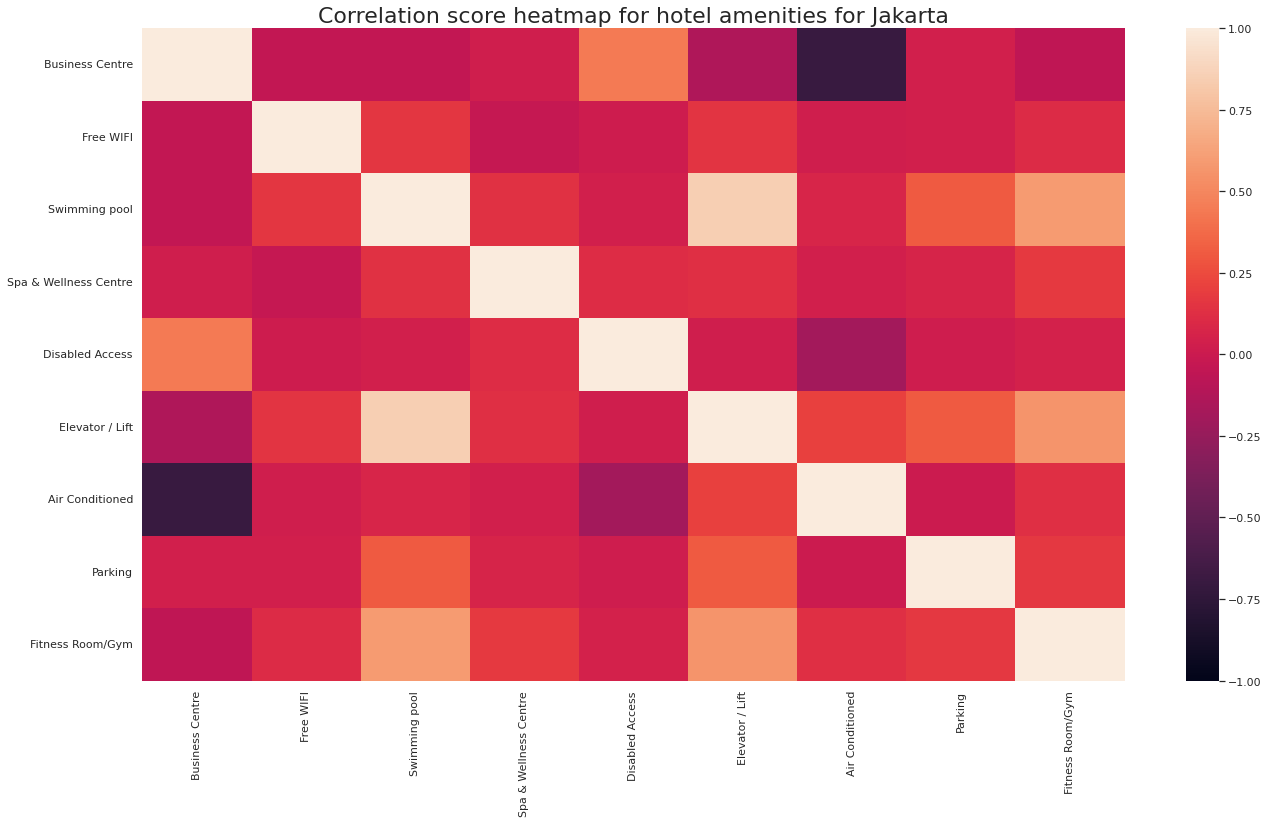

In [305]:
# preparing dataset to visualize amenities correlation heatmap and frequency heatmap
amenitiesToVisualize1 = amenitiesID.drop(columns=["hotel_id"])
fig, ax = plt.subplots(figsize = (22,12))
sns.heatmap(amenitiesToVisualize1.corr(), vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 26})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation score heatmap for hotel amenities for Jakarta", fontsize=22)


Text(0.5, 1.0, 'Correlation score heatmap for hotel amenities for London')

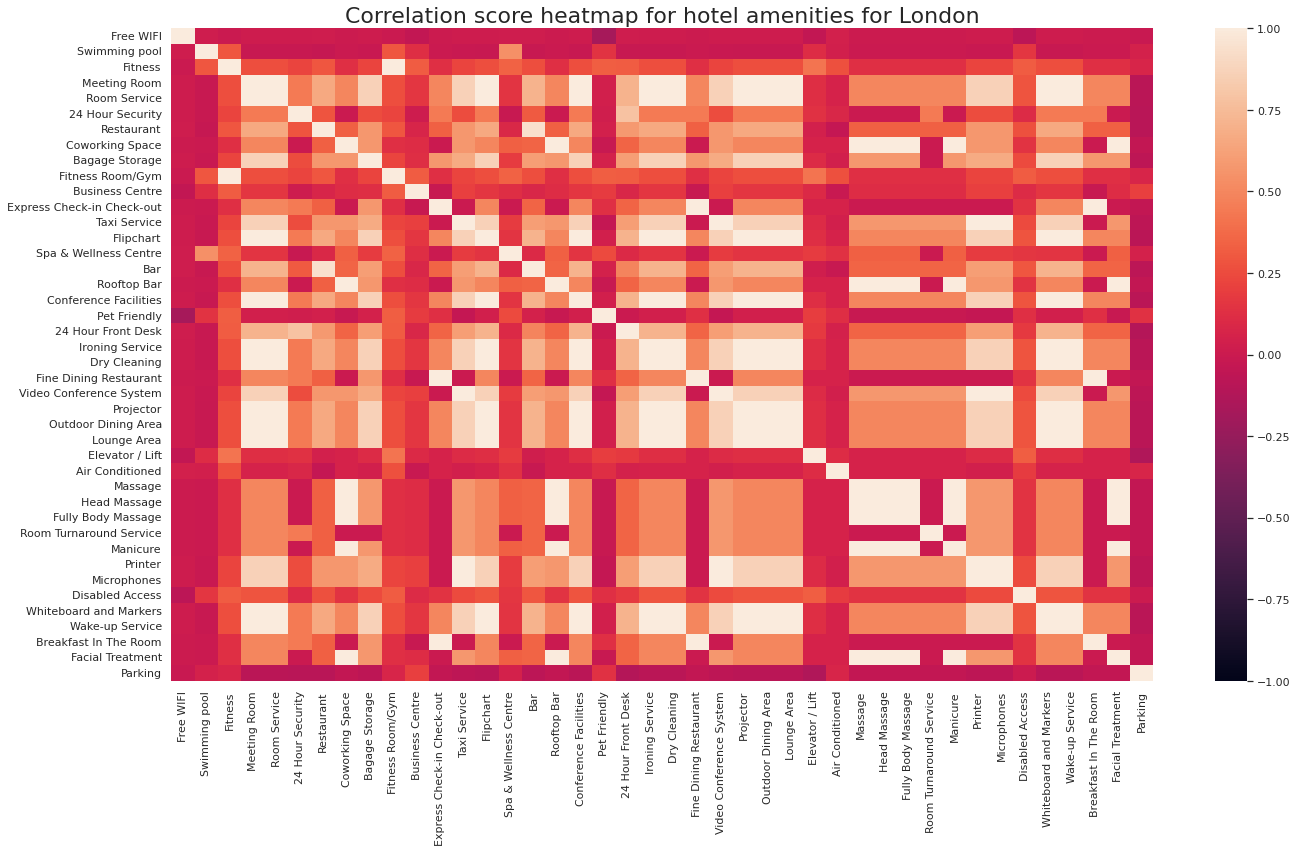

In [306]:
amenitiesToVisualize2 = amenitiesGB.drop(columns=["hotel_id"])
fig, ax = plt.subplots(figsize = (22,12))
sns.heatmap(amenitiesToVisualize2.corr(), vmin=-1, vmax=1)
plt.rcParams.update({'font.size': 26})
plt.xticks(rotation=90)
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation score heatmap for hotel amenities for London", fontsize=22)

### <br> Concusions: 
#### this time I showed the correlaton between amenities separately for each city:
#### - both cities shows different amount of amenities available in given hotels;
#### - most of amenities are highly correlated for London, so they are showing the same segment of characteristics;
#### - the same pairs of amenities showed slightly different level of correlation for Jakarta and London but the trend was similar for both cities<br>


### Creating final dataset for clustering analysis

In [307]:
# for all data
fileWorking = fileWorking.merge(amenitiesAll, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorking.columns = fileWorking.columns.str.lower()

# for Jakarta
fileWorkingID = fileWorkingID.merge(amenitiesID, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingID.columns = fileWorkingID.columns.str.lower()

# for London
fileWorkingGB = fileWorkingGB.merge(amenitiesGB, how="left", on="hotel_id").drop(columns=["amenity"])
fileWorkingGB.columns = fileWorkingGB.columns.str.lower()

## Data Cleaning

### Removing duplicates

In [308]:
# for all data
filesWorkingCleaned = fileWorking.drop_duplicates(subset=["hotel_id"], keep="first")
# for Jakarta
filesWorkingIDCleaned = fileWorkingID.drop_duplicates(subset=["hotel_id"], keep="first")
# for London
filesWorkingGBCleaned = fileWorkingGB.drop_duplicates(subset=["hotel_id"], keep="first")

### Handling inconsistent data

In [309]:
def mappingCategoricalData(seriesUnique):
    catData = {}
    for i, code in enumerate(seriesUnique):
        catData[code] = i+1
    return catData

#### handling information for hotel_currency_code

In [310]:
filesWorkingCleaned["hotel_currency_code"].isna().sum()

0

In [311]:
curr = filesWorkingCleaned["hotel_currency_code"].unique()
currCode = mappingCategoricalData(curr)
# for all data
filesWorkingCleaned["hotel_currency_code"] = filesWorkingCleaned["hotel_currency_code"].map(currCode)
# for Jakarta
filesWorkingIDCleaned["hotel_currency_code"] = filesWorkingIDCleaned["hotel_currency_code"].map(currCode)
# for London
filesWorkingGBCleaned["hotel_currency_code"] = filesWorkingGBCleaned["hotel_currency_code"].map(currCode)

#### handling information for hotel_country

In [312]:
filesWorkingCleaned["hotel_country"].isna().sum()

0

In [313]:
co = filesWorkingCleaned["hotel_country"].unique()
country = mappingCategoricalData(co)
# for all data
filesWorkingCleaned["hotel_country"] = filesWorkingCleaned["hotel_country"].map(country)
# for Jakarta
filesWorkingIDCleaned["hotel_country"] = filesWorkingIDCleaned["hotel_country"].map(country)
# for London
filesWorkingGBCleaned["hotel_country"] = filesWorkingGBCleaned["hotel_country"].map(country)

#### handling information for rooms_count

In [314]:
filesWorkingCleaned["rooms_count"].isna().sum()

0

#### handling information for hotel_distance 

In [315]:
filesWorkingCleaned["hotel_distance"].value_counts(dropna=False)

NaN      159
3.90      20
4.15      15
10.84     14
4.16       7
        ... 
7.12       1
7.33       1
5.85       1
15.10      1
1.32       1
Name: hotel_distance, Length: 515, dtype: int64

In [316]:
filesWorkingIDCleaned["hotel_distance"].value_counts(dropna=False)

3.90     20
4.15     14
10.84    14
NaN      12
4.16      7
         ..
12.00     1
3.33      1
8.51      1
6.91      1
2.43      1
Name: hotel_distance, Length: 383, dtype: int64

In [317]:
filesWorkingGBCleaned["hotel_distance"].value_counts(dropna=False)

NaN     147
3.84      4
1.60      3
4.03      3
2.39      3
       ... 
4.15      1
1.88      1
2.68      1
3.29      1
1.32      1
Name: hotel_distance, Length: 201, dtype: int64

#### There is lack of calculated hotel distance for 147 hotels in London and 12 for Jakarta so I used mean calculated per city o fill that data

In [318]:
mean1  = filesWorkingCleaned.loc[filesWorkingCleaned["hotel_country"]==1]["hotel_distance"].mean()
mean2  = filesWorkingCleaned.loc[filesWorkingCleaned["hotel_country"]==2]["hotel_distance"].mean()
filesWorkingIDCleaned["hotel_distance"].fillna(mean2, inplace=True)
filesWorkingGBCleaned["hotel_distance"].fillna(mean1, inplace=True)

In [319]:
filesWorkingCleaned["hotel_distance"] = np.where(np.isnan(filesWorkingCleaned["hotel_distance"])&(filesWorkingCleaned["hotel_country"]==1),mean1,filesWorkingCleaned["hotel_distance"])
filesWorkingCleaned["hotel_distance"] = np.where(np.isnan(filesWorkingCleaned["hotel_distance"])&(filesWorkingCleaned["hotel_country"]==2),mean2,filesWorkingCleaned["hotel_distance"])

#### handling information for hotel_lat and hotel_lon

In [320]:
#for all data
filesWorkingCleaned["hotel_lat"] = filesWorkingCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingCleaned["hotel_lon"] = filesWorkingCleaned["hotel_lon"].apply(lambda x: round(x,5))
# for Jakarta
filesWorkingIDCleaned["hotel_lat"] = filesWorkingIDCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingGBCleaned["hotel_lon"] = filesWorkingGBCleaned["hotel_lon"].apply(lambda x: round(x,5))
# for London
filesWorkingIDCleaned["hotel_lat"] = filesWorkingIDCleaned["hotel_lat"].apply(lambda x: round(x,5))
filesWorkingGBCleaned["hotel_lon"] = filesWorkingGBCleaned["hotel_lon"].apply(lambda x: round(x,5))

In [321]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["hotel_country", "hotel_city"])
filesWorkingGBCleaned = filesWorkingGBCleaned.drop(columns=["hotel_country", "hotel_city"])

filesWorkingIDCleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 648 entries, 0 to 647
Data columns (total 35 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   hotel_id               648 non-null    int64  
 1   hotel_currency_code    648 non-null    int64  
 2   hotel_lat              648 non-null    float64
 3   hotel_lon              648 non-null    float64
 4   hotel_distance         648 non-null    float64
 5   rooms_count            648 non-null    int64  
 6   4-star_hotel           648 non-null    int64  
 7   3-star_hotel           648 non-null    int64  
 8   5-star_hotel           648 non-null    int64  
 9   2-star_hotel           648 non-null    int64  
 10  aparthotel             648 non-null    int64  
 11  hostel                 648 non-null    int64  
 12  apartment_hotel_type   648 non-null    int64  
 13  guesthouse             648 non-null    int64  
 14  1-star_hotel           648 non-null    int64  
 15  boutiq

#### dropping columns that have only one value and it is 0 

In [322]:
filesWorkingIDCleaned = filesWorkingIDCleaned.drop(columns=["apartment", "double","family","single","studio","suite","triple","5-star_hotel", "aparthotel", "1-star_hotel", "boutique_hotel"])

#### dropping hotel_if for all data sets

In [323]:
allData = filesWorkingCleaned.drop(columns=["hotel_id"])
indonesia = filesWorkingIDCleaned.drop(columns=["hotel_id"])
gb = filesWorkingGBCleaned.drop(columns=["hotel_id"])

### Visualize heatmap for all hotels characteristics in Jakarta

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in Jakarta')

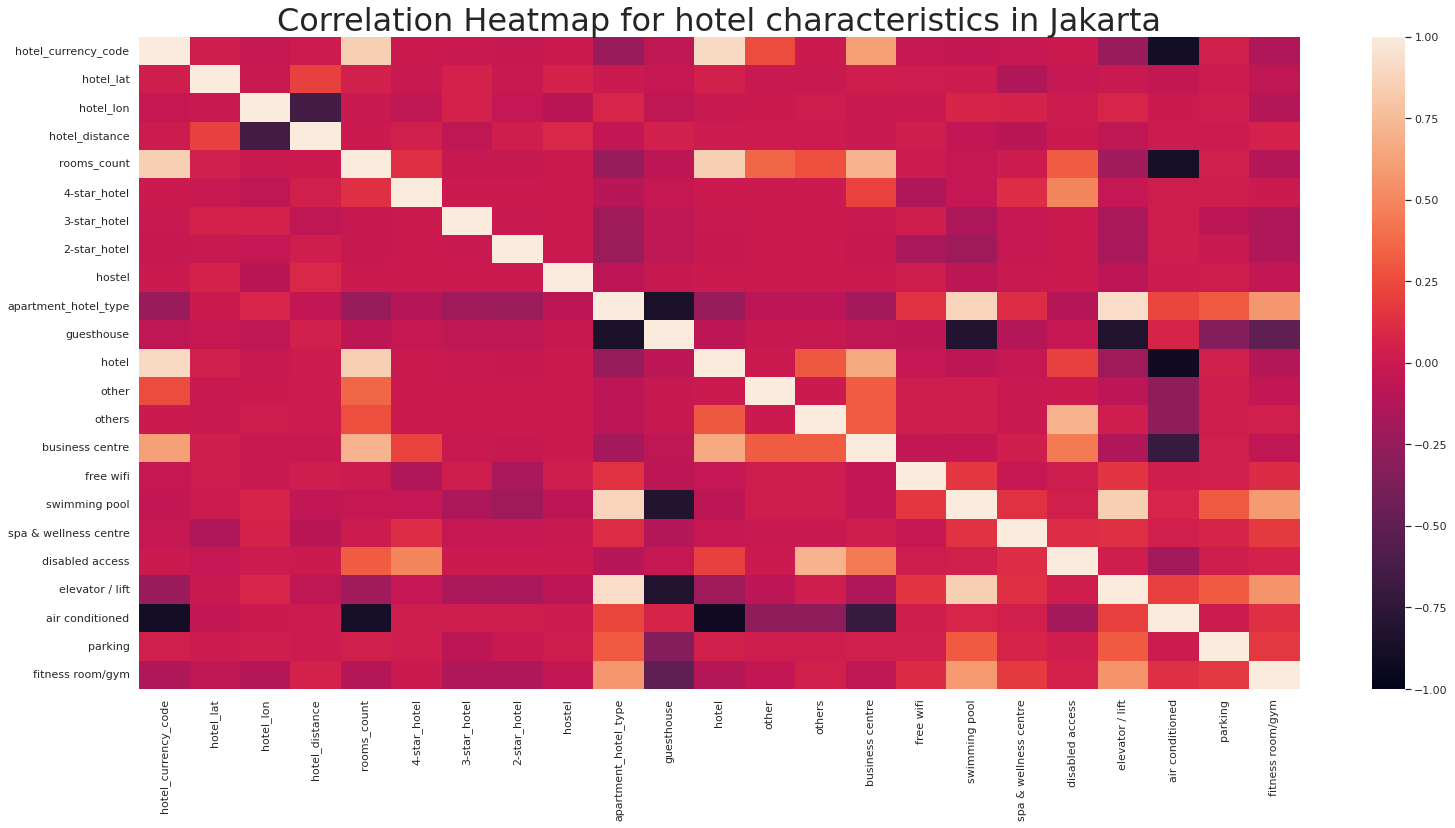

In [324]:

plt.figure(figsize=(26, 12))
plt.rcParams.update({'font.size': 36})
heatmap = sns.heatmap(indonesia.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in Jakarta", fontdict={"fontsize":32})

Text(0.5, 1.0, 'Correlation Heatmap for hotel characteristics in London')

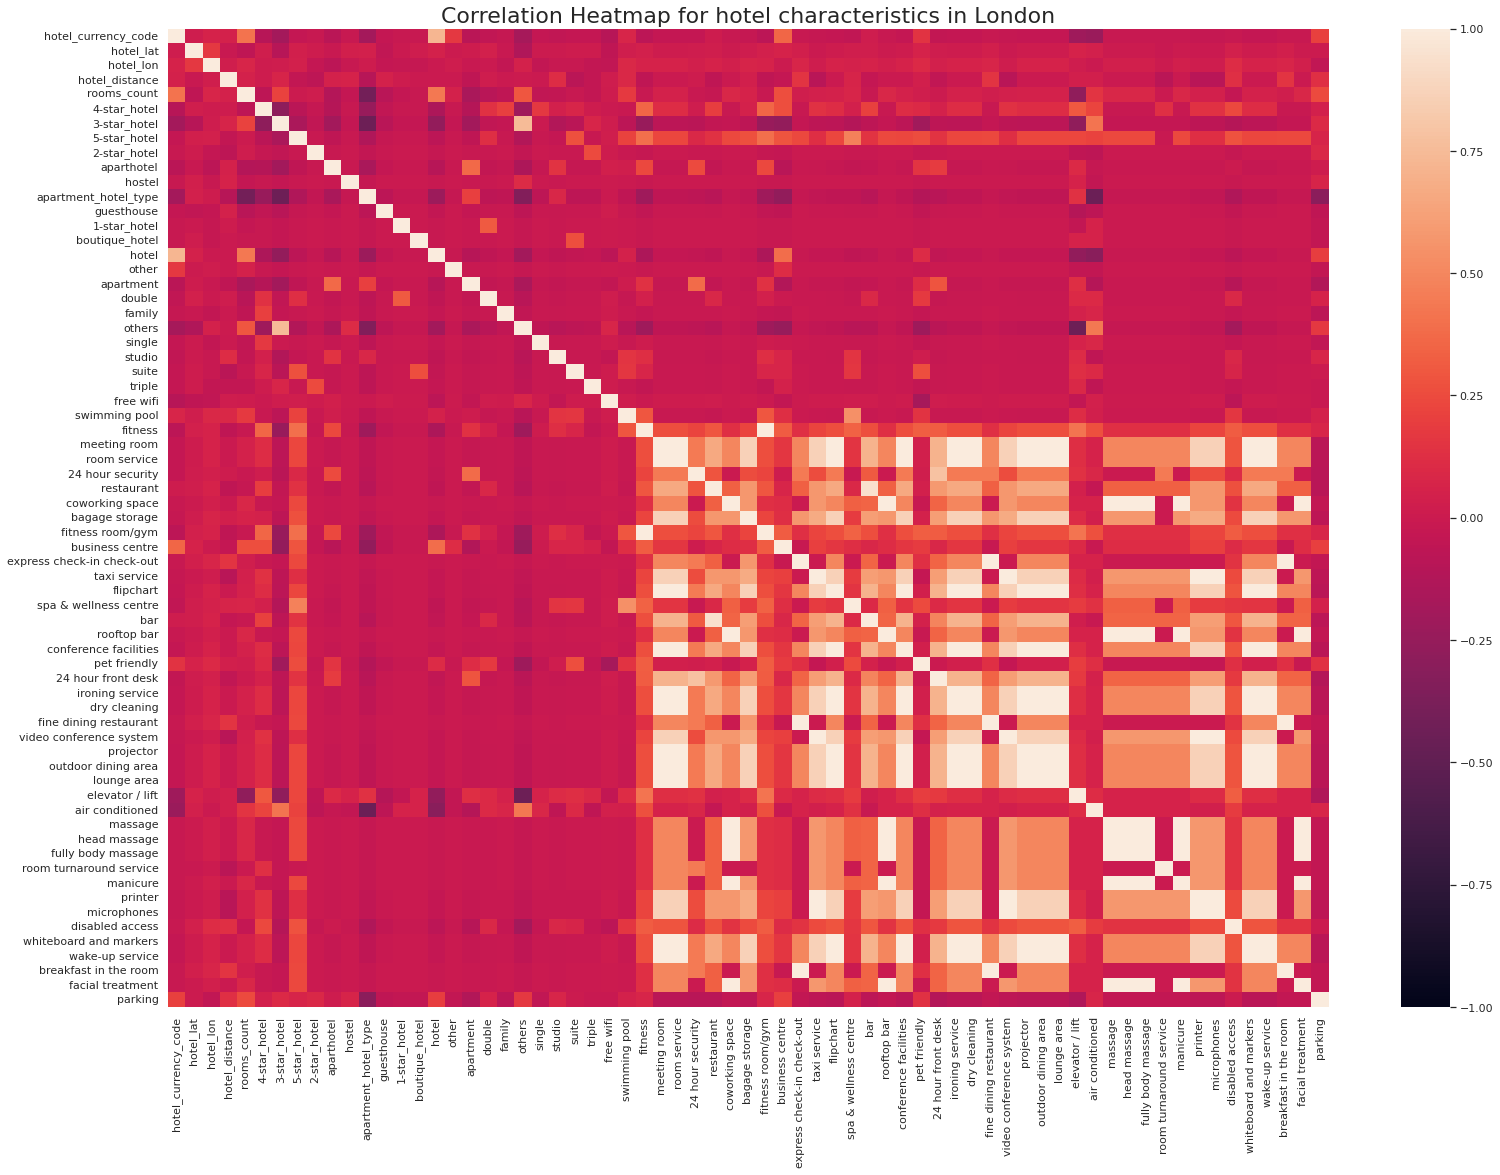

In [325]:

plt.figure(figsize=(26, 18))
plt.rcParams.update({'font.size': 22})
heatmap = sns.heatmap(gb.corr(),vmin=-1, vmax=1)
heatmap.set_title("Correlation Heatmap for hotel characteristics in London", fontdict={"fontsize":22})

### <br> Conclusions:
#### - both cities differ in the number of amenities available and in room types
#### - correlation scores for the same pairs of characteristics somoteimes differ in the value of the score but shows more or less the same trends eg elevator/lift-fitenssroom/gym,
#### but for some characteristics correlations score is typical only for the like negative correlation between hotel_type and swimming_pool or rooms_count and air_conditioning  for Jakarta
#### - depending on the analysis/ taken values to the algorythm all available data should be taken and highly correlated data should be removed using the below function to data reduction <br>


## Data Reduction

#### <br> **calc_vif** - a function that detects strong correlation and returns list of characteristics that should be removed. Here in the function they are listed to ne removed only these characteristics for which the VIF score was higher than 5.
#### **reduce_dimensions_by_pca** -a function that will be reducing dimentions if in the final dataset there will still be a lot of variables. <br>

In [326]:
def calc_vif(df):
    # Multicollinearity detection
    # df - dataFrame
    # col_names - names of columns you would like to calculate the VIF score   
    vif = pd.DataFrame()

    variables = df
    df_vif = add_constant(variables)
    vif["VIF"] = [variance_inflation_factor(df_vif.values, i) for i in range(df_vif.shape[1])]
    vif["variables"] = df_vif.columns
    vif["VIF"].replace([np.inf, -np.inf], np.nan, inplace=True)
    vifToReduce = vif.loc[(vif["VIF"].isnull())|(vif["VIF"]>5)]
    return vifToReduce["variables"].tolist()

def select_variables(df, col_names):
    # returning the 
    if "const" in col_names:       
        const_to_remove = col_names.index("const")
        del col_names[const_to_remove]

    df_selected_variables = df
    df_selected_variables.drop(columns=col_names, inplace=True)

    return df_selected_variables

In [327]:
gbToReduce = calc_vif(gb)
idToReduce = calc_vif(indonesia)
allToReduce = calc_vif(allData)

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning:

In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning:

divide by zero encountered in double_scalars

/home/agata/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning:

divide by zero encountered in double_scalars



#### <br> Removing from the working file variables which are highly correlated <br>

In [328]:
idReduced = select_variables(filesWorkingIDCleaned, idToReduce)
gbReduced = select_variables(filesWorkingGBCleaned, gbToReduce)
allReduced = select_variables(filesWorkingCleaned, allToReduce)

#### Creating copy that is not containing Hotel id for the analysis

In [329]:
idReducedAnalysis = idReduced.drop(columns=["hotel_id"])
gbReducedAnalysis = gbReduced.drop(columns=["hotel_id"])
allReducedAnalysis = allReduced.drop(columns=["hotel_id"])

In [330]:
#### ploting correlation heatmap for final hotel characteristics

(648, 8)

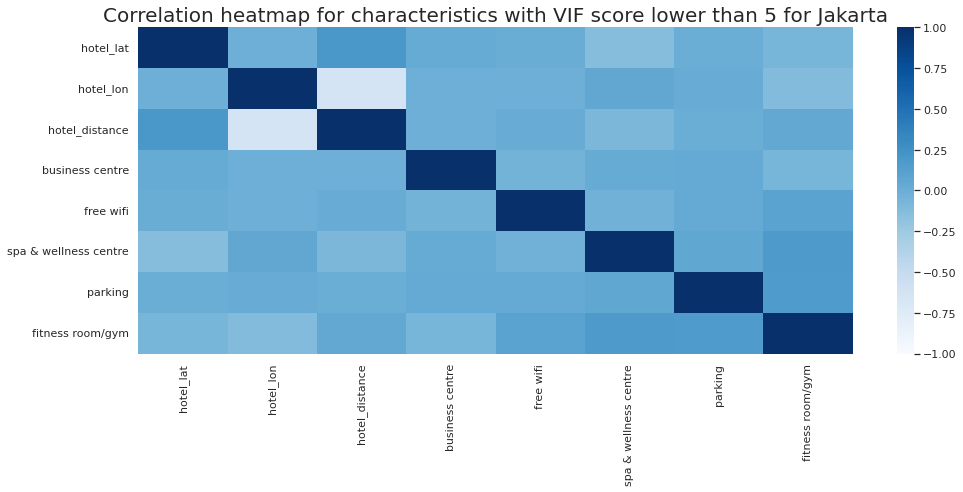

In [331]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(idReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for Jakarta", fontsize=20)
idReducedAnalysis.shape

(390, 22)

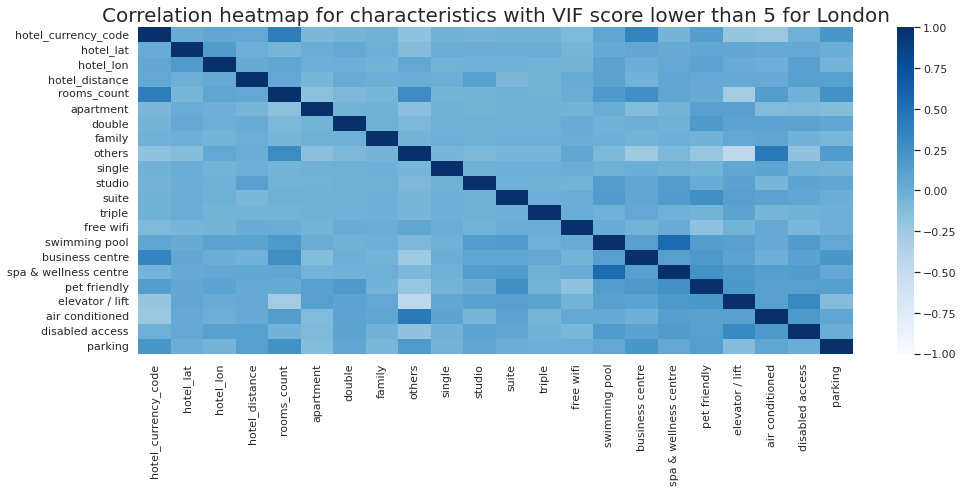

In [332]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(gbReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for London", fontsize=20)
gbReducedAnalysis.shape

(390, 22)

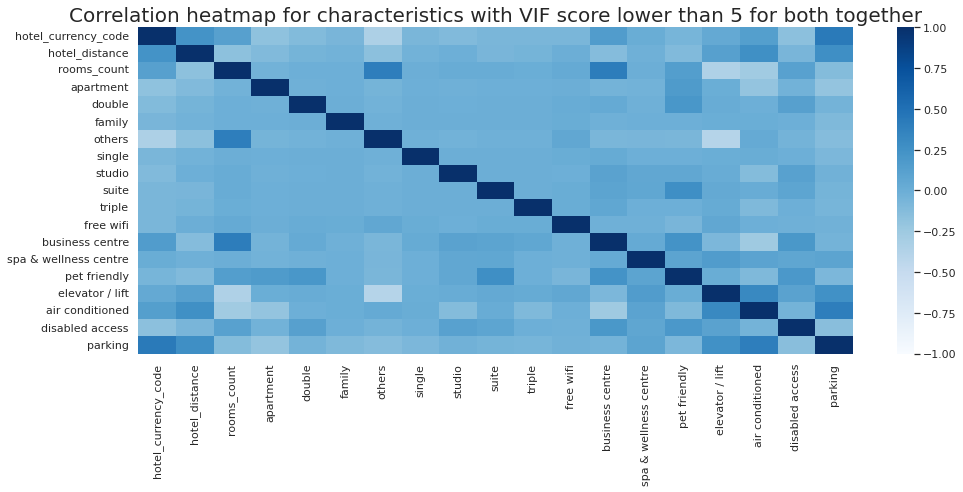

In [333]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(allReducedAnalysis.corr(),vmin=-1, vmax=1, cmap = "Blues")
plt.xticks(rotation=90)
plt.rcParams.update({'font.size': 20})
plt.savefig("heatmap.png", dpi = 300)
plt.title("Correlation heatmap for characteristics with VIF score lower than 5 for both together", fontsize=20)
gbReducedAnalysis.shape

In [334]:
allReducedAnalysis.shape

(1038, 19)

### <br> Conclusions:
#### - this time  function detecting multcolinearity was removing characteristics VIF score higher that 5 what was recomended by documantation, it reduced the dimentions to 12 for Jakarta, 22 for London and 20 for cumulative dataset.
#### - such restrict removing  <br>


## Standarizing data

In [335]:
scaler = StandardScaler()
# standarizing data from Jakarta
indo_std = scaler.fit_transform(idReducedAnalysis)
# standarizing data from London
gb_std = scaler.fit_transform(gbReducedAnalysis)
# standarizing cumulative data 
all_data_std = scaler.fit_transform(allReducedAnalysis)
all_data_std[:3]

array([[-1.09555704, -0.75689728, -0.02783747, -0.16127206,  3.29329498,
        -0.05899388, -0.31557819, -0.06598588, -0.09924928, -0.07006096,
        -0.06598588,  0.17835118, -0.27504121, -0.20788478, -0.22496064,
         0.75993921,  0.53203901, -0.21533919, -1.60987437],
       [-1.09555704, -0.42292634,  0.09839297, -0.16127206, -0.10138247,
        -0.05899388, -0.31557819, -0.06598588, -0.09924928, -0.07006096,
        11.34957145,  0.17835118, -0.27504121, -0.20788478, -0.22496064,
         0.75993921, -1.87956141, -0.21533919, -1.60987437],
       [-1.09555704, -1.16728531,  0.79839817, -0.16127206, -0.10138247,
        -0.05899388, -0.31557819, -0.06598588, -0.09924928,  8.48561865,
        -0.06598588,  0.17835118,  3.63581876, -0.20788478,  4.44522215,
         0.75993921, -1.87956141, -0.21533919,  0.62116648]])

## Removing Dimentions with PCA for Jakarta

In [336]:
pca_indoesia = PCA(n_components=0.95)
train_pca_indonesia = pca_indoesia.fit_transform(indo_std)
train_pca_indonesia[:1]

array([[-0.78765518,  2.72212699,  5.73155308,  4.00423519,  4.79112121,
         1.99782274, -0.12440215]])

### Showing how many components is responsible for  95% of variance

In [337]:
pca_indoesia.n_components_

7

### Explained Variance

In [338]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_indoesia.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.213675,0.213675,1
1,0.166833,0.380508,2
2,0.133420,0.513928,3
3,0.130239,0.644168,4
4,0.116108,0.760276,5
5,0.107294,0.867570,6
6,0.091564,0.959134,7


In [340]:
indonesia_reduced = pd.DataFrame(data=train_pca_indonesia.flatten())

## Removing Dimentions with PCA for London

In [341]:
pca_gb = PCA(n_components=0.95)
train_pca_gb = pca_gb.fit_transform(gb_std)
train_pca_gb[:1]

array([[ 0.15276063, -1.38685196,  0.73425252, -1.14217208, -0.2173667 ,
         0.55785988,  0.14654044,  0.33506589, -0.25967672, -0.75255621,
         0.26838389, -0.25901696, -1.04667706,  0.08358788, -0.30050109,
         0.76146672,  0.10877896, -0.59512138, -0.93385629]])

### Showing how many components explains 95% of variance

In [342]:
pca_gb.n_components_

19

### Explained Variance

In [343]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_gb.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.110036,0.110036,1
1,0.097931,0.207967,2
2,0.079171,0.287138,3
3,0.060198,0.347336,4
4,0.056802,0.404138,5
5,0.055324,0.459463,6
6,0.050987,0.510450,7
7,0.047273,0.557722,8
8,0.046106,0.603828,9
9,0.045406,0.649234,10


In [344]:
gb_reduced = pd.DataFrame(data=train_pca_gb.flatten())

## Removing dimensions for cumulative data

In [345]:
pca_all = PCA(n_components=0.95)
train_pca_all = pca_all.fit_transform(all_data_std)
train_pca_all[:1]

array([[ 0.73645011,  0.19176132, -1.89076371,  0.7670147 , -0.34225842,
         2.29265109,  0.42714672, -0.08619014,  0.01231624,  0.35548793,
        -0.91603314,  0.72837488, -1.01601559,  0.23910083,  1.07301692,
        -0.54970988,  0.58654777]])

### Showing how many components explains 95% of the variance

In [346]:
pca_all.n_components_

17

### Explained Variance

In [347]:
results = pd.DataFrame(data={"explained_variance_ratio":pca_all.explained_variance_ratio_})
results["cumulative"] = results["explained_variance_ratio"].cumsum()
results["component"] = results.index + 1
results

,explained_variance_ratio,cumulative,component
0,0.133870,0.133870,1
1,0.091754,0.225623,2
2,0.086583,0.312206,3
3,0.067130,0.379336,4
4,0.059167,0.438503,5
5,0.055695,0.494198,6
6,0.055370,0.549568,7
7,0.053317,0.602885,8
8,0.052849,0.655735,9
9,0.051643,0.707377,10


In [348]:
all_reduced = pd.DataFrame(data=train_pca_all.flatten())

### Conclusions:
#### - for Jakarta only 10 out of 12 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance
####  - for London only 20  out of 23 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance
#### - for both sets of data together 17 out of 20 characteristics were responsible for 95% of varianve in data, and how it is visible from cumulative component all of them more or less play the same role in variance

## DBSCAN Clustering analysis

### <br>There were performed 3 analysis:
#### 1. for Jakarta
#### 2. for London
#### 3. for combined both sets<br>

### 1. Jakarta

#### Calculating the eps and min_samples: typical way of calculating the min_samples is DIM+1 or DIMx2 - I choose the first option. To calculate  to calculate the average distance between each point and its n_neighbors is generally used the NearestNeighbors 

In [349]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(train_pca_indonesia)
distances, indices = neighbors_fit.kneighbors(train_pca_indonesia)

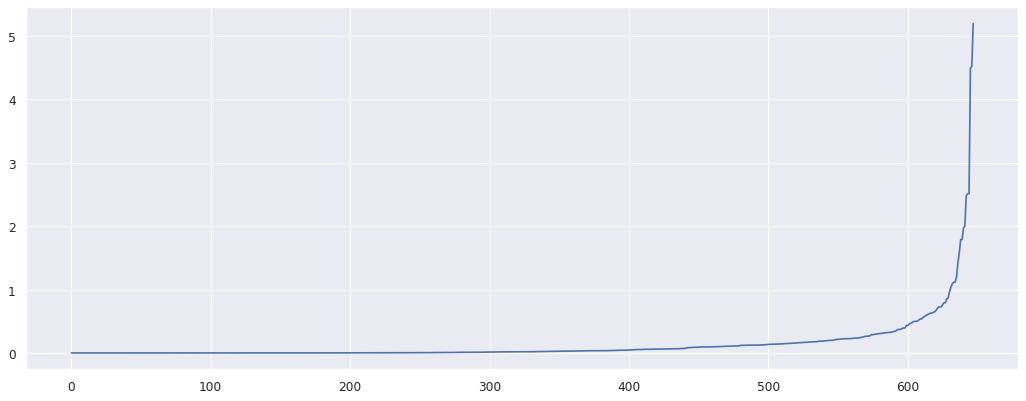

In [350]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [351]:
cluster = DBSCAN(eps=3,min_samples=2)
cluster.fit(train_pca_indonesia)

DBSCAN(eps=3, min_samples=2)

In [352]:
cluster.labels_[:]

array([-1,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  2,  3,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  2,  0,  0,  1,  0,  0,  1,  0,  0,  1,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  3,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        2,  0,  0,  0,  0

In [353]:
idReduced["cluster"] = cluster.labels_

In [354]:
idReduced

,hotel_id,hotel_lat,hotel_lon,hotel_distance,business centre,free wifi,spa & wellness centre,parking,fitness room/gym,cluster
0,52765,-6.25534,106.810825,6.180000,1,1,1,1,1,-1
1,506274,-6.17542,106.729023,13.450000,0,1,0,1,1,0
2,506275,-6.20835,106.818008,3.020000,0,1,0,1,0,0
3,506278,-6.22346,106.784432,6.840000,0,1,0,1,1,0
4,506279,-6.16237,106.832172,5.650000,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
643,589802,-6.22141,106.815778,6.915566,0,1,0,1,0,0
644,589803,-6.12715,106.790440,6.915566,1,1,0,1,0,6
645,589804,-6.26462,106.782179,6.915566,1,1,0,1,0,6
646,589805,-6.18720,106.821936,6.915566,1,1,0,1,0,6


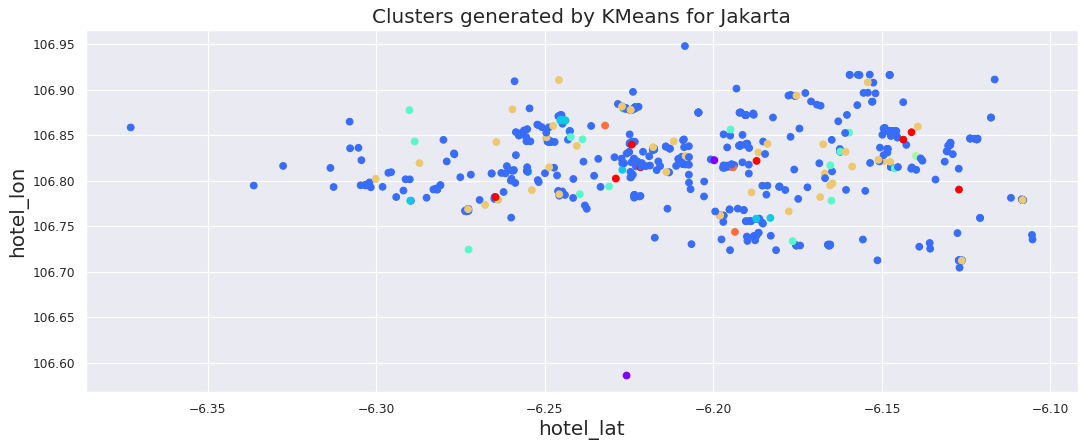

In [355]:
plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.title("Clusters generated by KMeans for Jakarta", **axis_font)
plt.xlabel("hotel_lat",**axis_font)
plt.ylabel("hotel_lon",**axis_font)
plt.scatter(idReduced["hotel_lat"], idReduced["hotel_lon"], c=idReduced["cluster"], cmap="rainbow")
plt.show()

### London

In [356]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(train_pca_gb)
distances, indices = neighbors_fit.kneighbors(train_pca_gb)

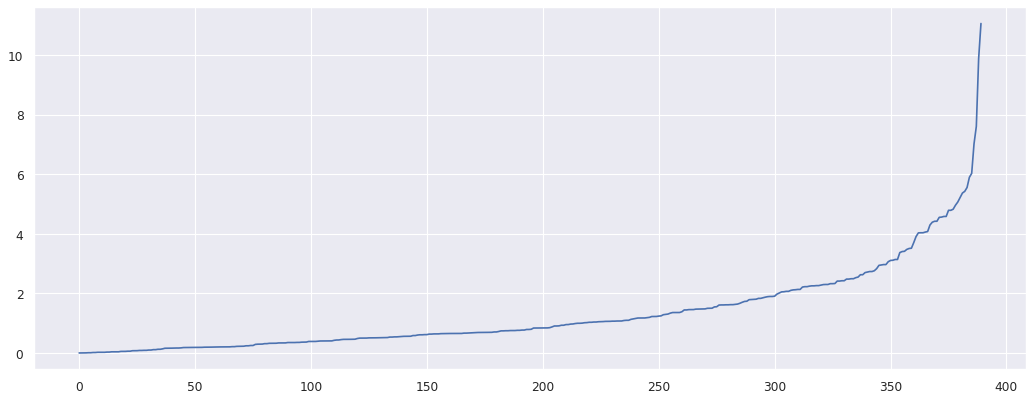

In [357]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [358]:
cluster = DBSCAN(eps=5,min_samples=2)
cluster.fit(train_pca_gb)

DBSCAN(eps=5, min_samples=2)

In [359]:
cluster.labels_[:]

array([ 0,  1,  0,  0,  0,  0,  0,  2,  0,  0,  1,  0,  3, -1,  0,  0,  0,
        4,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        5,  0,  0,  0, -1,  0,  0,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0,
       -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  6,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  7,  2,  0,
        0,  2,  5,  0,  0,  0, -1, -1,  0,  0, -1,  3,  0,  0,  0,  0,  0,
        1,  7,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  2,  0,  0,  0,  4,  0,  0,  0,  0,  8,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [360]:
gbReduced["cluster"] = cluster.labels_

In [361]:
gbReduced

,hotel_id,hotel_currency_code,hotel_lat,hotel_lon,hotel_distance,rooms_count,apartment,double,family,others,...,free wifi,swimming pool,business centre,spa & wellness centre,pet friendly,elevator / lift,air conditioned,disabled access,parking,cluster
0,5622,1,51.521259,-0.15586,3.120000,34,0.0,1.0,0.0,0.0,...,1,0,0,0,0,1,1,0,0,0
1,5630,1,51.512071,-0.18521,4.300000,45,0.0,0.0,0.0,0.0,...,1,0,0,0,0,1,0,0,0,1
2,5640,1,51.507706,-0.14714,1.670000,106,0.0,0.0,0.0,0.0,...,1,0,1,0,1,1,0,0,1,0
3,5671,1,51.490098,-0.13813,1.390000,72,0.0,3.0,0.0,0.0,...,1,0,0,0,0,1,1,0,0,0
4,5681,1,51.496872,-0.16760,2.890000,28,0.0,2.0,0.0,0.0,...,1,0,1,0,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385,589981,4,51.508232,0.04376,3.931276,225,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,1,0
386,590977,1,51.516015,-0.11857,1.840000,0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,1,1,0,1,0
387,592390,1,51.543948,-0.15233,5.200000,1,0.0,3.0,0.0,0.0,...,1,0,0,0,1,0,0,0,0,0
388,592405,1,51.511208,-0.11935,1.320000,0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,1,0,0


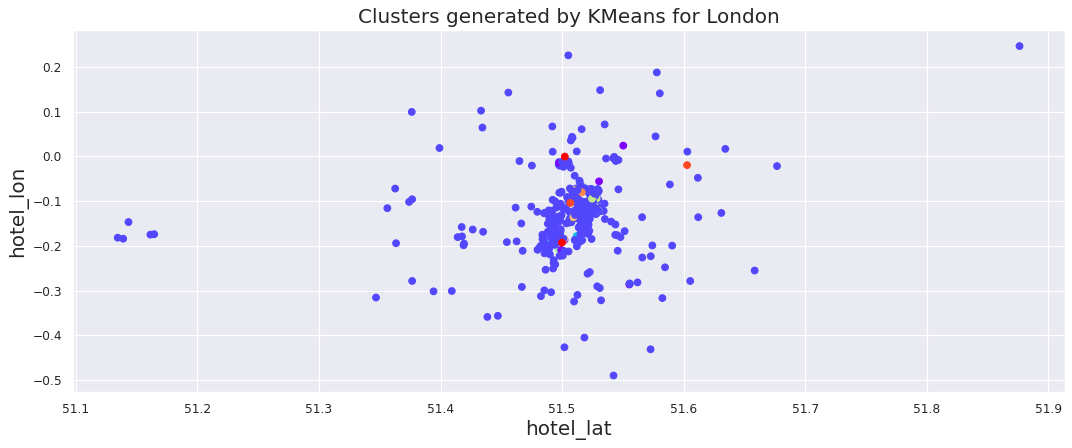

In [362]:
plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.title("Clusters generated by KMeans for London", **axis_font)
plt.xlabel("hotel_lat",**axis_font)
plt.ylabel("hotel_lon",**axis_font)
plt.scatter(gbReduced["hotel_lat"], gbReduced["hotel_lon"], c=gbReduced["cluster"], cmap="rainbow")
plt.show()

# All Data together

In [363]:
neighbors = NearestNeighbors(n_neighbors=2)
neighbors_fit = neighbors.fit(train_pca_all)
distances, indices = neighbors_fit.kneighbors(train_pca_all)

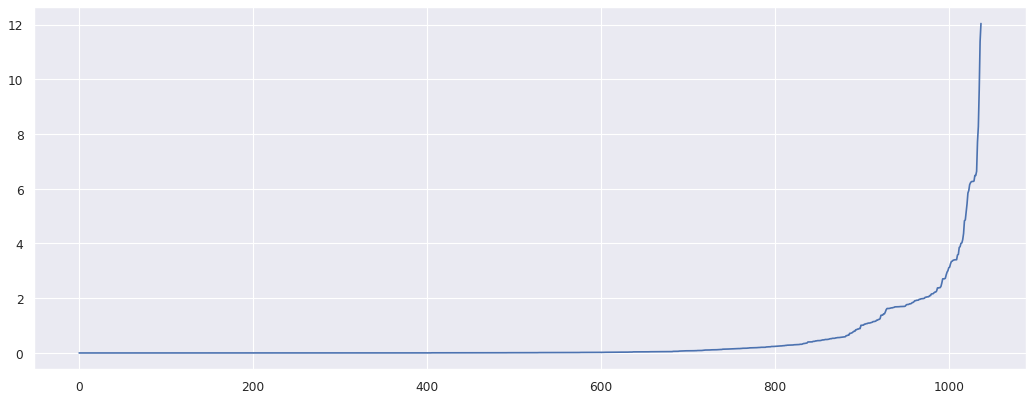

In [364]:
plt.figure(figsize=(16, 6), dpi=80)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [365]:
cluster = DBSCAN(eps=2,min_samples=2)
cluster.fit(train_pca_all)

DBSCAN(eps=2, min_samples=2)

In [366]:
cluster.labels_[:200]

array([-1,  0, -1, -1, -1,  1,  2,  3,  4,  4, -1,  5, -1, -1,  1, -1,  6,
        7, -1,  5,  6,  4,  4,  1,  1,  4,  1,  5, -1,  5,  5, -1,  8, -1,
        1, -1, -1, -1, -1,  7, -1, -1, -1, -1, -1, -1,  9, 10, -1,  5, -1,
        4, -1, -1, -1, -1,  1,  1,  1,  1,  1,  5,  1,  1,  1,  1,  1,  5,
        1,  1,  5,  1, -1,  5,  5,  5,  5,  5,  5,  5,  5, 11,  5,  5,  5,
        5,  1,  5,  5,  5,  5,  8,  1,  8,  8,  8,  1,  8,  1,  8, 11, -1,
        1,  1,  5,  5,  1,  1,  5,  5,  1, -1,  5,  1,  5, -1,  5, 12, -1,
        4,  6,  3, -1, 13,  1,  8,  8, -1,  2,  2, -1, -1, -1, 13, 14,  1,
        8,  0, -1,  1,  1, -1, -1,  1,  1,  5,  5,  5,  5,  5,  5,  1,  5,
        1,  5, -1,  4,  1,  5, -1,  4,  1,  5,  5, 12,  1,  1,  1,  1,  1,
        1,  1,  1, 15,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  5,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

In [367]:
allReduced["cluster"] = cluster.labels_

In [368]:
allReduced

,hotel_id,hotel_currency_code,hotel_distance,rooms_count,apartment,double,family,others,single,studio,...,triple,free wifi,business centre,spa & wellness centre,pet friendly,elevator / lift,air conditioned,disabled access,parking,cluster
0,5622,1,3.120000,34,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,1,1,0,0,-1
1,5630,1,4.300000,45,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1,0,0,0,1,0,0,0,0
2,5640,1,1.670000,106,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,1,0,0,1,-1
3,5671,1,1.390000,72,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,1,1,0,0,-1
4,5681,1,2.890000,28,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,1,0,0,1,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1033,589981,4,3.931276,225,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,0,1,24
1034,590977,1,1.840000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,1,0,1,1,1,0,1,-1
1035,592390,1,5.200000,1,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,1,0,0,0,0,-1
1036,592405,1,1.320000,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1,0,0,0,0,0,1,0,11


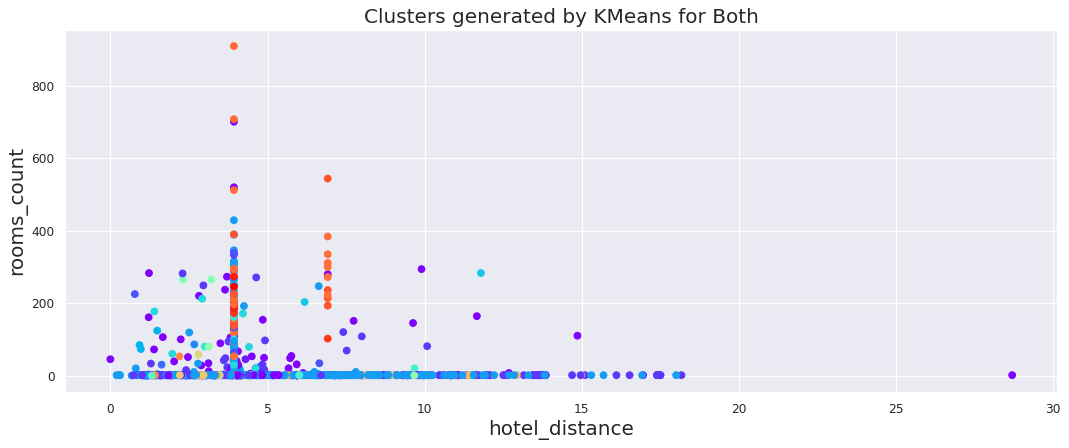

In [369]:
plt.figure(figsize=(16, 6), dpi=80)
axis_font = {'fontname':'Arial', 'size':'18'}
plt.title("Clusters generated by KMeans for Both", **axis_font)
plt.xlabel("hotel_distance",**axis_font)
plt.ylabel("rooms_count",**axis_font)
plt.scatter(allReduced["hotel_distance"], allReduced["rooms_count"], c=allReduced["cluster"], cmap="rainbow")
plt.show()

## <br> Concusions:<br>
#### 1. DBSCAN analysis for these 3 types of datasets created 6 clusters for Jakarta where different hotel types were 12, 10 for London where different hotel types were 18 and 26 when it was analysed both of them together - to understand if the clusters were correct I need to analysed the hotels and clusters chosen in for each country separately and in cumulative analysis. 
#### 2. The way how to define min_samples and eps so the main inputs to the DBSCAN should be verified because there are other ways to find that characteristics, to found the best fit way for dataset we have.
#### 3. PCA analysis and explained variance showed that every of the characteristics took more or less an equal part in explaining 95% of variability for these hotels so there are no characteristic that played the most role
#### 4. Removing the VIF score above 5 was to strict because it removed hotel_lat and hotel_lon and hotel_city for cumulative analysis.
#### 5. I will analyse clusters to see what was created by DBSCAN for these 3 set of analysis and I will play with different aproches to define <br>